# Install

In [2]:
#!pip install rdkit
#!pip install tensorflow
!pip install torch
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install pytorch-lightning

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/e4/ae/2ad8820045b6631965750435f28583e80905b8273d57cf026163b51323ee/torch-2.1.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/192.3 MB 1.7 MB/s eta 0:01:57
   ---------------------------------------- 0.2/192.3 MB 2.4 MB/s eta 0:01:22
   ---------------------------------------- 0.3/192.3 MB 2.3 MB/s eta 0:01:25
   ---------------------------------------- 0.5/192.3 MB 2.6 MB/s eta 0:01:13
   ---------------------------------------- 0.7/192.3 MB 3.3 MB/s eta 0:00:59
   ---------------------------------------- 1.0/192.3 MB 3.6 MB/s eta 0:00:54
   ---------------------------------------- 1.2/192.3 MB 3.7 MB/s eta 0:00:52
   ---------------------------------------- 1.4/192.3 MB 3.9 MB/s eta 0:00:49
   ---------------------------------------- 1.6/192.3 MB 4.0 MB/s eta 0:00:48
   --------------------

# Import

In [4]:
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
import time

# Machine Learning
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def RF(x_train, y_train):
    # Define the parameter grid for GridSearchCV
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_features': [None,'sqrt', 'log2'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Create a GridSearchCV object
    rf = RandomForestRegressor(random_state=42)
    #return rf
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)  # Adjust number of splits as needed

    random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=kfold, verbose=1, scoring='neg_mean_squared_error')

    # Fit the GridSearchCV object
    random_search.fit(x_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_
    print(random_search.best_params_)

    return best_model

def XGB(x_train, y_train):
    # Define the parameter grid for RandomizedSearchCV
    param_dist = {
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300, 400]
    }

    # Create a RandomizedSearchCV object
    xgb = XGBRegressor(random_state=42)
    #return xgb
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust number of splits as needed

    random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, cv=kfold, verbose=1,
                                       scoring='neg_mean_squared_error')

    # Fit the RandomizedSearchCV object
    random_search.fit(x_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_
    print(random_search.best_params_)

    return best_model

def SVR_M(x_train, y_train):
    # Define the parameter grid for RandomizedSearchCV
    param_dist = {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': np.logspace(-3, 3, 7),
        'epsilon': [0.1, 0.2, 0.5, 0.01]
    }

    # Create a RandomizedSearchCV object
    svr = SVR()
    #return svr
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust number of splits as needed

    random_search = RandomizedSearchCV(svr, param_distributions=param_dist, n_iter=10, cv=kfold, verbose=1, scoring='neg_mean_squared_error')

    # Fit the RandomizedSearchCV object
    random_search.fit(x_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_
    print(random_search.best_params_)

    return best_model


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam

#import pytorch_lightning as L
from torch.utils.data import TensorDataset, DataLoader
class FCN(nn.Module):

    def __init__(self, N_Input, N_Output, N_Hidden, N_Layer):
      super().__init__()
      activation = nn.Tanh
      self.fcs = nn.Sequential(*[
          nn.Linear(N_Input, N_Hidden),
          activation()])
      self.fch = nn.Sequential(*[
                  nn.Sequential(*[
                    nn.Linear(N_Hidden, N_Hidden),
                    activation()]) for _ in range(N_Layer-1)])
      self.fce = nn.Linear(N_Hidden, N_Output)

      self.learning_rate = 0.01

    def forward(self, input):
      x = self.fcs(input)
      x = self.fch(x)
      x = self.fce(x)
      return x

def DL(x_train, y_train):
    temp_tensor = x_train[x_train.shape[1]-1].reset_index(drop=True)

    x_train = x_train.drop(columns=x_train.shape[1]-1)
    inputs = torch.tensor(x_train.values)
    labels = torch.tensor(y_train.values)

    dataset = TensorDataset(inputs, labels)
    dataloader = DataLoader(dataset)

    model = FCN(x_train.shape[1], 1, 200, 3)
    optimizer = Adam(model.parameters(), lr=0.001)

    for epoch in range(50):
      total_loss = 0

      for iteration in range(len(inputs)):
        #print(iteration)
        input_i = inputs[iteration]

        temp_i = torch.tensor(temp_tensor[iteration])
        label_i = labels[iteration]

        #print(label_i)
        output_i = model(input_i)
        loss = sum((output_i - label_i)**2)

        #Psat_pre = Psat_cal(temp_i, output_i[0], output_i[1], output_i[2])
        #Psat_an = Psat_cal(temp_i, label_i[0], label_i[1], label_i[2])
        #loss2 = (Psat_an - Psat_pre)**2

        loss_all = loss
        #print(f"loss1 : {loss}  loss2: {loss2}")
        loss_all.backward()

        total_loss += float(loss)

      optimizer.step()
      optimizer.zero_grad()

      if(epoch%5 == 0):
        print(f"Step: {epoch} , output : {output_i.detach().numpy()},  loss : {loss_all}")

    '''
    model = Sequential()
    model.add(Dense(2048, input_dim=x_train.shape[1] , activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
    '''
    return model

In [5]:
# %% Package
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

# Our module
#from Python_MLModel import RF, Ridge_M, XGB, NN, DT, SVR_M, KNN
#from Python_Scoring_Export import Scoring, Export

def Psat_cal(T,A,B,C):
    #return pow(A-(B/(T+C)),10)/(10^(3))
    return A-(B/(T+C))
def generateTemp(Tmin, Tmax, amountpoint):
    Trange = Tmax-Tmin
    T_arr =[]
    for i in range(amountpoint):
        Tgen = Tmin+(Trange*random.random())
        T_arr.append(Tgen)
    return T_arr

# Work

In [6]:
#%% Import Data
df = pd.read_csv("../New_Data_Psat_Not_Outliers.csv")
df = df[df['SMILES'] != "None"].reset_index(drop=True)
df.sort_values(by="No.C")

,Unnamed: 0,Name,SMILES,A,B,C,Tmin,Tmax,No.C
0,0,Methanal,C=O,21.370292,2204.126554,-30.150,190,271,1
36,36,Formamide,C(=O)N,23.311763,5274.025104,-44.106,391,466,1
30,30,Hydrogen cyanide,C#N,21.886463,2886.895994,-20.307,261,300,1
29,29,Methanamine,CN,21.976333,2419.234054,-35.320,203,288,1
1543,1543,Methyl diazene,CN=N,23.568524,3308.561494,0.000,195,236,1
...,...,...,...,...,...,...,...,...,...
1776,1776,"4-Ethyl-2,6-dimethyloctane",CCC(C)CC(CC)CC(C)C,20.181583,3271.766184,-85.150,463,463,12
1777,1777,"3-Ethyl-2,7-dimethyloctane",CCC(CCCC(C)C)C(C)C,20.161320,3298.660378,-87.150,469,469,12
1778,1778,"4-Ethyl-2,7-dimethyloctane",CCC(CCC(C)C)CC(C)C,20.181583,3271.766184,-85.150,463,463,12
1268,1268,trans-6-Dodecene,CCCCC/C=C/CCCCC,20.482162,3391.194366,-107.729,437,487,12


In [7]:
df1 = df.copy()
T_Test = generateTemp(df1["Tmin"], df1["Tmax"], 5)
T_all = []
for i in range(len(T_Test[0])):
    T_gen_x_point = [item[i] for item in T_Test]
    T_all.append(T_gen_x_point)

df1["T"] = T_all
df1  = df1.explode('T')
df1['T'] = df1['T'].astype('float32')
#df1 = df1.drop(columns={"Column1"})
df1 = df1.reset_index(drop=True)



Psat_test = Psat_cal(df1["T"], df1["A"], df1["B"], df1["C"])
df1["Vapor_Presssure"] = Psat_test

df2 = df1[["SMILES", "T", "Vapor_Presssure"]]
# Select feature for data: X=SMILE, Y=Tb
X_data_excel= df2[["SMILES"]]
Y_data= df2["Vapor_Presssure"]

In [8]:
# %% Fingerprint
# Generate Fingerprint from SMILE
MF_radius = 3
MF_bit = 4096

X_data_use = X_data_excel.copy()
X_data_use["molecule"] = X_data_use["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
X_data_use["count_morgan_fp"] = X_data_use["molecule"].apply(lambda x: rdMolDescriptors.GetHashedMorganFingerprint(
    x,
    radius=MF_radius,
    nBits=MF_bit,
    useFeatures=True, useChirality=True))
X_data_use["arr_count_morgan_fp"] = 0
#X_data_use["arr_count_morgan_fp"] = np.zeros((0,), dtype=np.int8)

#X_data_use["arr_count_morgan_fp"]
#new_df = X_data_use.apply(DataStructs.ConvertToNumpyArray, axis=0, args=('count_morgan_fp',))


# Transfrom Fingerprint to Column in DataFrame
X_data_fp = []
for i in range(X_data_use.shape[0]):
    #print(np.array(X_data_use["morgan_fp"][i]))
    blank_arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(X_data_use["count_morgan_fp"][i],blank_arr)
    datafram_i = pd.DataFrame(blank_arr)
    datafram_i = datafram_i.T
    X_data_fp.append(datafram_i)
x_data_fp = pd.concat(X_data_fp, ignore_index=True)
x_data_fp = x_data_fp.astype(np.float32)
y_data_fp = Y_data.copy()

In [9]:
# %% MinMaxScaler
#x_data_fp = df2[["Temp_test"]].join(x_data_fp)
x_data_fp[MF_bit] = df2["T"]

"""
from sklearn.preprocessing import MinMaxScaler
# Define the scaler for the last column
scaler_col3 = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data
scaler_col3.fit(x_data_fp[MF_bit].values.reshape(-1, 1))

# Transform the data using the fitted scaler
x_data_fp[MF_bit] = scaler_col3.transform(x_data_fp[MF_bit].values.reshape(-1, 1))
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\n# Define the scaler for the last column\nscaler_col3 = MinMaxScaler(feature_range=(0, 1))\n\n# Fit the scaler to the data\nscaler_col3.fit(x_data_fp[MF_bit].values.reshape(-1, 1))\n\n# Transform the data using the fitted scaler\nx_data_fp[MF_bit] = scaler_col3.transform(x_data_fp[MF_bit].values.reshape(-1, 1))\n'

In [10]:
#%% Train-test split
x_train_fp, x_test_fp, y_train_fp, y_test_fp = train_test_split(x_data_fp, y_data_fp,test_size=0.2,random_state=42)

In [11]:
models = []


In [12]:
#%% Training Model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

def model_assess(X_train, X_test, y_train, y_test, list_model, name_model, title = "Default"):
  model_assess_table = pd.DataFrame(['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2']).transpose()
  new_header = model_assess_table.iloc[0] #grab the first row for the header
  model_assess_table.columns = new_header #set the header row as the df header
  model_assess_table.drop(index=model_assess_table.index[0], axis=0, inplace=True)

  train_prediction_table = pd.DataFrame(['Method','Training Predict','Training Actual']).transpose()
  new_header = train_prediction_table.iloc[0] #grab the first row for the header
  train_prediction_table.columns = new_header #set the header row as the df header
  train_prediction_table.drop(index=train_prediction_table.index[0], axis=0, inplace=True)

  test_prediction_table = pd.DataFrame(['Method','Test Predict','Test Actual']).transpose()
  new_header = test_prediction_table.iloc[0] #grab the first row for the header
  test_prediction_table.columns = new_header #set the header row as the df header
  test_prediction_table.drop(index=test_prediction_table.index[0], axis=0, inplace=True)

  for iteration in range(len(list_model)):
      model = list_model[iteration]
      name = name_model[iteration]
      if(name != "DL"):
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)
      else:
        X_train = X_train.drop(columns=X_train.shape[1]-1)
        X_test = X_test.drop(columns=X_test.shape[1]-1)
        y_train_pred = model(torch.tensor(X_train.values)).detach().numpy()
        y_test_pred  = model(torch.tensor(X_test.values)).detach().numpy()

      train_mae = mean_absolute_error(y_train, y_train_pred)
      train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
      train_r2 = r2_score(y_train, y_train_pred)
      test_mae = mean_absolute_error(y_test, y_test_pred)
      test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
      test_r2 = r2_score(y_test, y_test_pred)

      results = pd.DataFrame([name_model[iteration],train_mae, train_rmse, train_r2, test_mae, test_rmse, test_r2]).transpose()
      results.columns = ['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2']

      train_prediction_result = pd.DataFrame([name_model[iteration],y_train_pred, y_train]).transpose()
      train_prediction_result.columns = ['Method','Training Predict','Training Actual']

      test_prediction_result = pd.DataFrame([name_model[iteration], y_test_pred, y_test]).transpose()
      test_prediction_result.columns = ['Method','Test Predict','Test Actual']

      model_assess_table = pd.concat([model_assess_table, results])
      train_prediction_table = pd.concat([train_prediction_table, train_prediction_result])
      test_prediction_table = pd.concat([test_prediction_table, test_prediction_result])
  return model_assess_table, train_prediction_table, test_prediction_table

In [13]:
all_result_model = []
#names = ["XGB", "RF", "SVM"]
names = ["XGB", "RF", "DL"]
#models = [XGB, RF, SVR_M]
models = [XGB, RF, DL ]
for iteration in range(len(names)) :
    get_model = models[iteration]
    result_model = get_model(x_train_fp, y_train_fp)
    all_result_model.append(result_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
result_evaluation, train_prediction, test_prediction = model_assess(x_train_fp, x_test_fp, y_train_fp, y_test_fp, all_result_model, names)
result_evaluation = result_evaluation.reset_index(drop=True)
train_prediction = train_prediction.reset_index(drop=True).explode(['Training Predict', 'Training Actual'])
test_prediction = test_prediction.reset_index(drop=True).explode(['Test Predict', 'Test Actual'])

In [ ]:
x_train_fp[4096]
y_train_fp.shape

In [ ]:
result_evaluation

In [ ]:
def checknum(x):
  if(isinstance(x, list)):
    return x[0]
  elif(isinstance(x, list)):
    return x.astype(float)
  else:
    return x

test_prediction['Test Predict'] = test_prediction['Test Predict'].apply(lambda x: checknum(x))
train_prediction['Training Predict'] = train_prediction['Training Predict'].apply(lambda x: checknum(x))

In [ ]:
test_prediction.head()

In [ ]:
train_prediction.head()

In [ ]:
#%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = min(min(test_prediction["Test Predict"]),min(test_prediction["Test Actual"]))-20
x_max = max(max(test_prediction["Test Predict"]),max(test_prediction["Test Actual"]))+20
y_min, y_max = x_min, x_max


#width = 6; height = 6  # Define desired figure width and height in inches
#plt.figure(figsize=(width, height)) # Create the figure with specified size

#g = sns.FacetGrid(test_prediction, height = 6)
sns.scatterplot(y="Test Predict", x="Test Actual",
                hue ="Method", alpha = 0.4,
                data = test_prediction)#,height = 6)#, edgecolor="w")

x = np.linspace(x_min, x_max, 100)
y = x
plt.plot(x, y, color='black',linestyle='dashed', label='Perfect line')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

In [ ]:
#%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = -20; x_max = 25
y_min, y_max = x_min, x_max


#width = 6; height = 6  # Define desired figure width and height in inches
#plt.figure(figsize=(width, height)) # Create the figure with specified size

#g = sns.FacetGrid(test_prediction, height = 6)
sns.scatterplot(y="Test Predict", x="Test Actual",
                hue ="Method", alpha = 0.4,
                data = test_prediction)#,height = 6)#, edgecolor="w")

x = np.linspace(x_min, x_max, 100)
y = x
plt.plot(x, y, color='black',linestyle='dashed', label='Perfect line')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.show()

In [ ]:
# Play an audio beep. Any audio URL will do.
#from google.colab import output
#output.eval_js('new Audio("http://commondatastorage.googleapis.com/codeskulptor-assets/Epoq-Lepidoptera.ogg").play()')

In [ ]:
from IPython.display import  Audio
path = r"C:\Users\Kan\Desktop\Entertainment\Granny go Japan!.mp3"
Audio(data = path, autoplay = True)

# Other

In [ ]:
Score_table = Scoring(model , x_train_fp, x_test_fp, x_data_fp, y_train_fp, y_test_fp, y_data_fp)
Score_table

,MAE,MAPE(%),RMSE,R2
0,1.132564,43.518056,4.035922,0.999995
1,3.495013,22.448103,105.699054,0.998651
2,1.605053,39.304065,47.407689,0.999492


In [ ]:
df_compare.to_csv("Psat_XGB df_compare.csv")
df_compare.describe()

,Actual,Predict,diff
count,2472.000000,2472.000000,2472.000000
mean,-73.528874,-75.399117,3.495013
std,2878.830714,2949.050781,105.662630
min,-103908.942410,-103691.476562,0.000328
25%,7.388535,7.633193,0.249024
50%,9.266151,8.809414,0.695651
75%,10.957195,10.071705,1.461511
max,18.593934,13.515080,5230.455383


In [ ]:
df2.to_csv("SMILES T VP.csv")
df2.describe()

,T,Vapor_Presssure
count,12360.000000,12360.000000
mean,378.901733,-33.684320
std,68.954262,2102.710871
min,31.580156,-108918.554064
25%,330.729584,7.553508
50%,377.764725,9.354368
75%,434.005257,10.964432
max,707.570557,19.034139


,Name,SMILES,A,B,C,Tmin,Tmax,No.C,T,Vapor_Presssure
3458,Tetrahydro-2-pyra,C1CCOC(=O)C1,21.549572,4231.944168,-58.490,310,481,5,323.907471,5.605089
6306,"N,N-Diethyl-benzeneacetamide",CCN(CC)C(=O)CC1=CC=CC=C1,29.227173,9959.371303,-200.000,404,460,12,452.604401,-10.199580
2536,Vinyl butanoate,CCCC(=O)OC=C,23.695972,4722.650380,0.000,1,390,6,338.627075,9.749508
5522,3-Methyliso-quinoline,CC1=CC2=CC=CC=C2C=N1,21.048575,4040.304616,-102.038,449,529,10,484.071686,10.472794
88,Benzoic acid,C1=CC=C(C=C1)C(=O)O,23.964385,5631.595845,-69.779,52,392,7,79.652267,-546.423875
85,Benzoic acid,C1=CC=C(C=C1)C(=O)O,23.964385,5631.595845,-69.779,52,392,7,206.020752,-17.370931
373,Propenoic acid,C=CC(=O)O,24.148246,5030.084634,-15.491,300,415,3,309.352966,7.031078
3429,tert-Butyl nitrite,CC(C)(C)ON=O,22.530795,3707.162000,0.000,267,337,4,279.788422,9.280919
3425,tert-Butyl nitrite,CC(C)(C)ON=O,22.530795,3707.162000,0.000,267,337,4,298.710144,10.120229


In [ ]:
mask1 = ~df_compare.index.isin(index_drop)
df_filtered1 = df_compare[mask1]
mask2 = ~df_compare_train.index.isin(index_drop)
df_filtered2 = df_compare_train[mask2]

print(df_filtered1, df_compare.shape)
print(df_filtered2, df_compare_train.shape)

          Actual    Predict      diff
8521   11.794613  11.492599  0.302014
10157  11.522621  11.556660  0.034039
7881   11.781488  11.046391  0.735097
4874   11.521377  10.220207  1.301170
11421   5.124626   6.930711  1.806085
...          ...        ...       ...
4844    8.801434   8.275676  0.525759
6598    9.022426   8.419917  0.602509
4688    8.130596   8.225019  0.094423
5267    6.973288   6.998631  0.025344
5938   -3.285856  -2.586786  0.699070

[2465 rows x 3 columns] (2472, 3)
          Actual    Predict      diff
4872   11.521377  10.220207  1.301170
11456   5.116719   7.924514  2.807795
10306  11.522786  11.574267  0.051481
5712    9.553718   9.131176  0.422542
5117    9.131644   9.665966  0.534322
...          ...        ...       ...
11964   3.809080   7.049675  3.240595
5191   11.786141  10.124437  1.661704
5390    9.800776   9.329654  0.471122
860    10.188328   8.569486  1.618842
7270    8.497814   9.203400  0.705586

[9886 rows x 3 columns] (9888, 3)


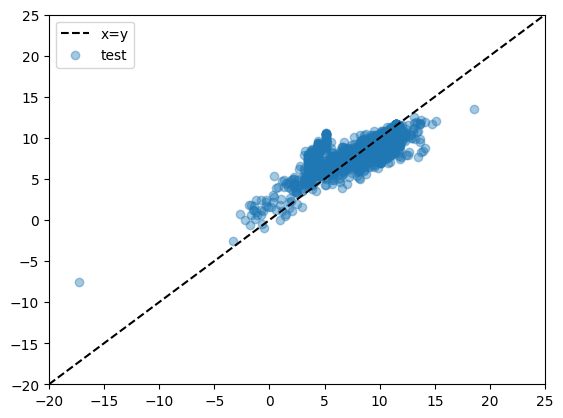

In [ ]:
#%% Visualization
#x_min = min(min(y_test_fp),min(y_pred_test))
#x_max = max(max(y_test_fp),max(y_pred_test))

x_min = -20; x_max = 25

y_min, y_max = x_min, x_max

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

x = np.linspace(x_min, x_max, 100)
y = x
p3 = plt.plot(x, y, color='black',linestyle='dashed', label='x=y')

#plt.scatter(df_filtered2["Actual"], df_filtered2["Predict"], label="train", alpha=0.3)
plt.scatter(df_filtered1["Actual"], df_filtered1["Predict"], label="test", alpha=0.4)
plt.legend()
#Score_table = Scoring(model , x_train_fp, x_test_fp, x_data_fp, y_train_fp, y_test_fp, y_data_fp)

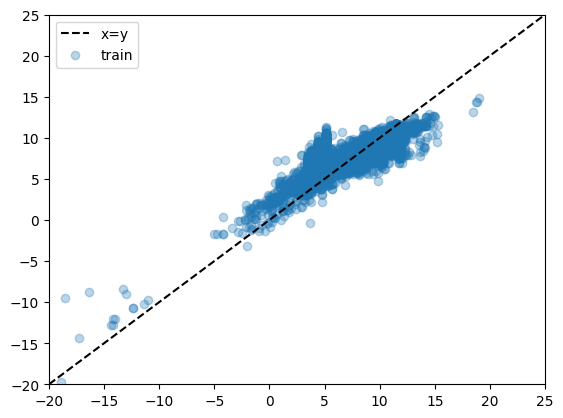

In [ ]:
#%% Visualization
#x_min = min(min(y_test_fp),min(y_pred_test))
#x_max = max(max(y_test_fp),max(y_pred_test))

x_min = -20; x_max = 25

y_min, y_max = x_min, x_max

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

x = np.linspace(x_min, x_max, 100)
y = x
p3 = plt.plot(x, y, color='black',linestyle='dashed', label='x=y')

plt.scatter(df_filtered2["Actual"], df_filtered2["Predict"], label="train", alpha=0.3)
#plt.scatter(df_filtered1["Actual"], df_filtered1["Predict"], label="test", alpha=0.4)
plt.legend()
#Score_table = Scoring(model , x_train_fp, x_test_fp, x_data_fp, y_train_fp, y_test_fp, y_data_fp)

In [ ]:
x_train_nnn = x_train_fp[~x_train_fp.index.isin(index_drop)]
x_test_nnn = x_test_fp[~x_test_fp.index.isin(index_drop)]
x_data_nnn = x_data_fp[~x_data_fp.index.isin(index_drop)]
y_train_nnn = y_train_fp[~y_train_fp.index.isin(index_drop)]
y_test_nnn = y_test_fp[~y_test_fp.index.isin(index_drop)]
y_data_nnn = y_data_fp[~y_data_fp.index.isin(index_drop)]


Score_table2 = Scoring(model , x_train_nnn, x_test_nnn, x_data_nnn, y_train_nnn, y_test_nnn, y_data_nnn)
Score_table2



,MAE,MAPE(%),RMSE,R2
0,1.132631,43.525265,4.036301,0.999995
1,3.315528,22.412943,105.457514,0.998661
2,1.568291,39.311690,47.250560,0.999495
